# Introduction to Correlated Data Lab

## Correlated States

Read [this](http://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/) FiveThirtyEight article about 2016 polling.

Suppose you were advising a Presidential candidate's pollster in the 2020 election. 

The pollster took polls in every state/region with electoral votes, treated each state as "independent coin flips," and estimated the probability of your candidate winning by simulating 1,000,000 elections. (This is an example of [Monte Carlo simulations](http://www.palisade.com/risk/monte_carlo_simulation.asp)!)

**Question:** What suggestions do you have for the pollster? Specifically, discuss how appropriate the assumption of independence is in this case and suggest improvements if you feel any are necessary.

**Answer:**
- more tolerance for a swing
- weighting states by electoral votes and 'swingyness factor' (volatility index)
- consider diversifying the methods with which you acquire data (phone, fax, telegram, carrier pigeon) different locations for polling that are representative of the proportional demographic you are trying to target (i.e. trump fans aren't shopping at the whole foods and going to yoga)
- clustering across the country, viewing voting tendencies without regard to state boundaries
- vary cluster size such that each cluster could be considered independent

## Correlated Stock Prices

You're interested in the performance of a particular stock. You use the [autocorrelation function](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html) in Pandas to assess how autocorrelated your stock's values are.

Autocorrelation makes explicit the idea of temporal correlation we discussed previously. Suppose we wanted to see how correlated a stock's prices are with the immediately preceding day's stock prices. 

| Day | Price | Price with Lag = 1 | Price with Lag = 2 |
|-----|-------|--------------------|--------------------|
| 1   | 25    | NA                 | NA                 |
| 2   | 26    | 25                 | NA                 |
| 3   | 28    | 26                 | 25                 |
| 4   | 24    | 28                 | 26                 |
| 5   | 23    | 24                 | 28                 |

Autocorrelation with a lag of 1 will calculate the correlation between column "Price" and column "Price with Lag = 1." Autocorrelation with a lag of $k$ will calculate the correlation between stock price and the stock price of $k$ days before in a similar manner.

I build a loop that iterates through days (we'll assume our stock price is the closing price at every day) 1 to 365 to assess how correlated a stock price is with the stock price from $i$ days ago. (Sample code seen below.)

```
for i in range(1, 366):
    print(df[stock_prices].autocorr(lag=i))
```

**Question:** Suppose my highest values of autocorrelation are found when $i = 1, 7, 30, 365$. What do each of these suggest about the performance of this particular stock?

**Answer:** For values of 1, 7, 30, and 365, we'd likely conclude that there is a correlation in the price at daily lags (day prior), weekly, monthly, and yearly intervals

In [1]:
!ls

all_stocks_5yr.csv  README.md  starter-code.ipynb


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('./all_stocks_5yr.csv')

df['date'] = pd.to_datetime(df.copy()['date'])

# create a subset of the total data with just amazon
df_amzn = df[df['Name'] == 'AMZN']

# free up some sweet, sweet space
df = None

# make sure the dates are sorted, newest first
df_amzn = df_amzn.copy().sort_values('date')

df_amzn.head(2)

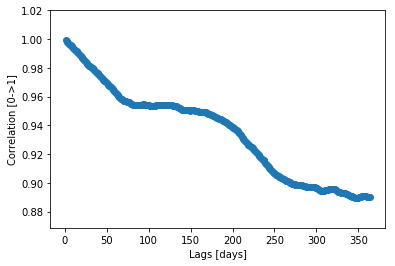

In [34]:
lags = []
cc = []
for i in range (1, 365):
    lags.append(i)
    cc.append(df_amzn['close'].autocorr(i))
#     print('{} days lag, {} coef'.format(i, df_amzn['close'].autocorr(i)))

df_lag = pd.DataFrame({'lags': lags, 'cc': cc})

plt.scatter(df_lag['lags'], df_lag['cc'])
plt.xlabel('Lags [days]')
plt.ylabel('Correlation [0->1]')
plt.show()

Stock prices vary quite rapidly. Looking at almost any plot of stock price over time, we'll see a very "wiggly" function that moves around erratically. Building a model for this can be difficult.

One way to "de-noise" or "smooth" this is to create a [moving average](http://www.investopedia.com/terms/m/movingaverage.asp) of stock prices. Suppose I wanted to create a moving average of stock prices across $k$ days. In this case, I create a new column that takes the current day and $k-1$ previous days (for $k$ total days) and average the stock prices of these days.

For example, I have a column of stock prices and a column associated with a moving average for three days. Then, my row for Day 5 includes the Day 5 stock price and the average of Day 3, Day 4, and Day 5 stock prices. (We'll go more in detail with this later.)

| Day | Price | Moving Average k = 3 |
|-----|-------|----------------------|
| 1   | 25    | NA                   |
| 2   | 26    | NA                   |
| 3   | 28    | 26.33                |
| 4   | 24    | 26                   |
| 5   | 23    | 25                   |

**Question:** As the number of periods $k$ increases, how do I expect my plotted curve to change?

**Answer:**

In [69]:
# drop cols if they're already there
try:
    df_amzn.drop([3, 5, 10], axis=1, inplace=True)
except:
    pass

In [70]:
for ma in [3, 5, 10]:
    df_amzn[ma] = df_amzn['close'].rolling(window=ma, center=True).mean()

In [71]:
df_amzn[['close', 3, 5, 10]].head(12).T

,46387,46388,46389,46390,46391,46392,46393,46394,46395,46396,46397,46398
close,261.95,257.210000,258.700000,269.470000,269.240000,265.090000,269.750000,266.410000,265.940000,265.420000,259.870,259.360000
3,NaN,259.286667,261.793333,265.803333,267.933333,268.026667,267.083333,267.366667,265.923333,263.743333,261.550,260.826667
5,NaN,NaN,263.314000,263.942000,266.450000,267.992000,267.286000,266.522000,265.478000,263.400000,262.768,262.434000
10,NaN,NaN,NaN,NaN,NaN,264.918000,264.710000,264.925000,265.380000,264.860000,264.510,265.312000


In [74]:
# this is the first 10 days moving 
# average, first sample (needs 10 days
# of data to make a data point)
df_amzn['close'][:10].mean()

264.91800000000001

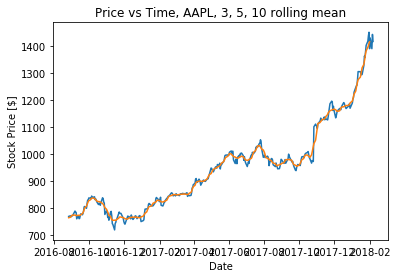

In [72]:
# I commented out the 3 and 5 day moving avgs to 
# keep the chart uncluttered
plt.plot(df_amzn['date'].iloc[-365:], df_amzn['close'].iloc[-365:])
# plt.plot(df_amzn['date'].iloc[-365:], df_amzn[3].iloc[-365:])
# plt.plot(df_amzn['date'].iloc[-365:], df_amzn[5].iloc[-365:])
plt.plot(df_amzn['date'].iloc[-365:], df_amzn[10].iloc[-365:])
plt.xlabel('Date')
plt.ylabel('Stock Price [$]')
plt.title('Price vs Time, AAPL, 3, 5, 10 rolling mean')
plt.show()

**Question:** Suppose we use our moving average to predict values of the stock price. As $k$ increases, how is the bias of our predictions affected? As $k$ increases, how is the variance of our predictions affected?

**Answer:** The smaller the moving average, the higher variance (lower bias) we'd have. The line is 'mo squiggly'.

**BONUS:** Recall that convolutional neural networks usually include a convolutional layer and a pooling layer. Suppose we have an array of stock prices and we want to apply a one-dimensional convolutional layer to the data. Specifically, we want to create a moving average of $k$ days. 

**Question:** What would the filter be here? (Remember that your filter should be fixed; it should not depend on the values of the data you have.)

*Hint: Assume you have the data [2, 4, 4, 6, 8] and you want to convolve it to create a moving average for $k = 2$. Your answer should be [3, 4, 5, 7].*

**Answer:**

In [120]:
from keras.layers import Convolution1D
import tensorflow as tffilters, kernel_size, strides=1filters, kernel_size, strides=1

In [3]:
import tensorflow as tf

tf.layers.conv1d(tf.convert_to_tensor([2, 4, 4, 6, 8]), 2, 2).get_config()

In [119]:
foo.get_config()

{'activation': 'linear',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dilation_rate': (1,),
 'filters': 2,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'kernel_size': (2,),
 'name': 'conv1d_14',
 'padding': 'valid',
 'strides': (1,),
 'trainable': True,
 'use_bias': True}

In [114]:
foo.call(tf.convert_to_tensor([1,2,3,4,5]))

AttributeError: 'Conv1D' object has no attribute 'kernel'